In [1]:
cd /orange/adamginsburg/salt/sanhueza/NGC6334IN/

/orange/adamginsburg/salt/sanhueza/NGC6334IN


In [2]:
ls

IN_1.reg
IN_2
IN_3.reg
IN_3_sm.reg
NaCl_v_le_3_stackcube.fits
NGC_6334_I_N.config8.allchannels_avg.selfcal_0.5_hogbom.image.fits
NGC_6334_I_N.config8.spw0.robust0.5.image_cb_smaller.fits
NGC_6334_I_N.config8.spw0.robust0.5.image_IN3_smaller.fits
NGC_6334_I_N.config8.spw0.robust0.5.image_small.fits
NGC_6334_I_N.config8.spw1.robust0.5.image_cb_smaller.fits
NGC_6334_I_N.config8.spw1.robust0.5.image_IN3_smaller.fits
NGC_6334_I_N.config8.spw1.robust0.5.image_small.fits
NGC_6334_I_N.config8.spw2.robust0.5.image_cb_smaller.fits
NGC_6334_I_N.config8.spw2.robust0.5.image_IN3_smaller.fits
NGC_6334_I_N.config8.spw2.robust0.5.image_small.fits
NGC_6334_I_N.config8.spw3.robust0.5.image_cb_smaller.fits
NGC_6334_I_N.config8.spw3.robust0.5.image_IN3_smaller.fits
NGC_6334_I_N.config8.spw3.robust0.5.image_small.fits
spectra/


In [3]:
%matplotlib inline
import pylab as pl
from spectral_cube import SpectralCube
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x2ac2dcba1340>

In [4]:
from astropy.table import Table
from astropy import table

In [5]:
import pprint

In [6]:
import scipy, scipy.ndimage

In [7]:
import numpy as np
import os
import glob
from astropy import constants, units as u, table, stats, coordinates, wcs, log, coordinates as coord
import radio_beam
import pyspeckit
import pylab as pl
from astroquery.splatalogue.utils import minimize_table as mt
import sys
sys.path.append('/orange/adamginsburg/salt/Orion_ALMA_2016.1.00165.S/analysis')
import lines
import paths
from salt_tables import (salt_tables, salt_table_names, SO, SO2, HCl, sis_tables, AlCl, AlF, Al37Cl,
                         NaF, AlO, AlOH, NaCN, CaS, CaO)

In [8]:
import regions
from astropy import units as u, coordinates
reg = regions.Regions.read('IN_3.reg')
regsm = regions.Regions.read('IN_3_sm.reg')
#regvsm = regions.Regions.read('verysmall.reg')
#regvvsm = regions.Regions.read('innerdiskbox.reg')

# NaCl Stackl

In [9]:
from spectral_cube.analysis_utilities import stack_cube

In [10]:
nacltables = salt_tables[3:5]

In [11]:
import spectral_cube.analysis_utilities
import imp
imp.reload(spectral_cube.analysis_utilities)
from spectral_cube.analysis_utilities import stack_cube

In [12]:
flist = (glob.glob('NGC_6334_I_N.config8.spw[0-3].robust0.5.image_small.fits'))

In [13]:
for fn in flist:
    for rr,regn in ((reg, 'IN3'),):
        outfile = fn.replace("_small",f"_{regn}_smaller")
        if not os.path.exists(outfile) or (os.path.exists(outfile) and SpectralCube.read(outfile).unit != u.K):
            cube = SpectralCube.read(fn, use_dask=True).subcube_from_regions(rr).to(u.K)
            cube.allow_huge_operations=True
            cb = cube.beams.common_beam(max_iter=20, max_epsilon=0.01)
            scube = cube.convolve_to(cb)
            scube.to(u.K).write(outfile, overwrite=True)

In [14]:
regn = "IN3"
cubes = [SpectralCube.read(fn).subcube_from_regions(reg)
         for fn in (glob.glob(f'NGC_6334_I_N.config8.spw[0-3].robust0.5.image_{regn}_smaller.fits'))]

cubes

[SpectralCube with shape=(3840, 60, 60) and unit=K:
  n_x:     60  type_x: RA---SIN  unit_x: deg    range:   260.227389 deg:  260.227571 deg
  n_y:     60  type_y: DEC--SIN  unit_y: deg    range:   -35.754898 deg:  -35.754750 deg
  n_s:   3840  type_s: FREQ      unit_s: Hz     range: 233562724480.800 Hz:235437314159.321 Hz,
 SpectralCube with shape=(3840, 60, 60) and unit=K:
  n_x:     60  type_x: RA---SIN  unit_x: deg    range:   260.227389 deg:  260.227571 deg
  n_y:     60  type_y: DEC--SIN  unit_y: deg    range:   -35.754898 deg:  -35.754750 deg
  n_s:   3840  type_s: FREQ      unit_s: Hz     range: 231062724274.800 Hz:232937313953.321 Hz,
 SpectralCube with shape=(3840, 60, 60) and unit=K:
  n_x:     60  type_x: RA---SIN  unit_x: deg    range:   260.227389 deg:  260.227571 deg
  n_y:     60  type_y: DEC--SIN  unit_y: deg    range:   -35.754898 deg:  -35.754750 deg
  n_s:   3840  type_s: FREQ      unit_s: Hz     range: 219062723285.979 Hz:220937312964.500 Hz,
 SpectralCube with sha

In [15]:
# only needed for VRSCs
if hasattr(cubes[0], 'beams'):
    beams = radio_beam.Beams(beams=[cube.beams.common_beam(max_iter=20, max_epsilon=0.01) for cube in cubes])
    cb=beams.common_beam()

In [16]:
linelist = np.concatenate([data['Freq'][(data['vu'] <= 3) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)].quantity
                             for data in nacltables])
linenames = np.concatenate( [data['Species'][(data['vu'] <= 3) &
                                          np.any([((data['Freq'].quantity > cube.spectral_extrema[0]) &
                                                   (data['Freq'].quantity < cube.spectral_extrema[1]))
                                                 for cube in cubes],
                                                 axis=0)]
                             for data in nacltables] )
(linelist, linenames)

(<Quantity [217.980231, 219.614936, 232.509977, 234.251912] GHz>,
 array(['23Na-35Clv=2-2 J=17-16', '23Na-35Clv=1-1 J=17-16',
        '23Na-35Clv=1-1 J=18-17', '23Na-35Clv=0-0 J=18-17'], dtype='<U24'))

In [17]:
from astropy import log
log.setLevel('INFO')

In [18]:
#log.setLevel('DEBUG')
vcen = -5 * u.km/u.s # from Patricio
stack, cutouts = stack_cube(cubes,
                   linelist=linelist,
                   vmin=vcen-30*u.km/u.s,
                   vmax=vcen+30*u.km/u.s,
                   average=np.nanmean,
                   convolve_beam=cb,
                   return_cutouts=True)
#log.setLevel('INFO')
stack.write('NaCl_v_le_3_stackcube.fits', overwrite=True)

In [19]:
stackc = SpectralCube.read('NaCl_v_le_3_stackcube.fits')
stackc

SpectralCube with shape=(91, 60, 60) and unit=K:
 n_x:     60  type_x: RA---SIN  unit_x: deg    range:   260.227389 deg:  260.227571 deg
 n_y:     60  type_y: DEC--SIN  unit_y: deg    range:   -35.754898 deg:  -35.754750 deg
 n_s:     91  type_s: VRAD      unit_s: km / s  range:      -35.216 km / s:      25.225 km / s

In [20]:
jtok = stackc.beam.jtok(217*u.GHz)

All-NaN slice encountered
invalid value encountered in true_divide


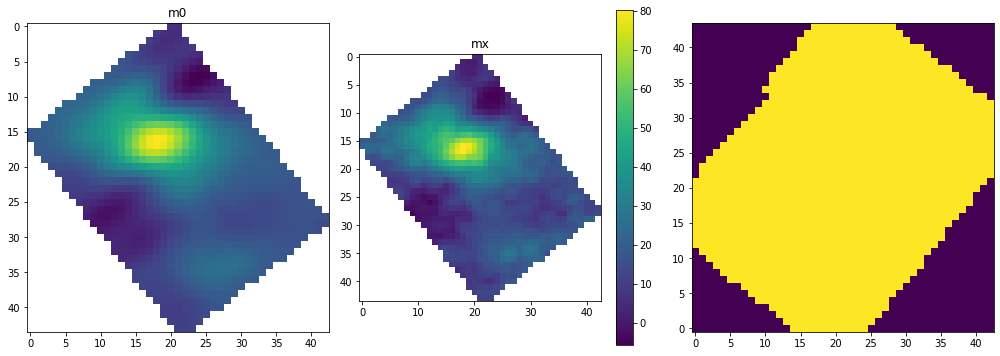

<Figure size 432x288 with 0 Axes>

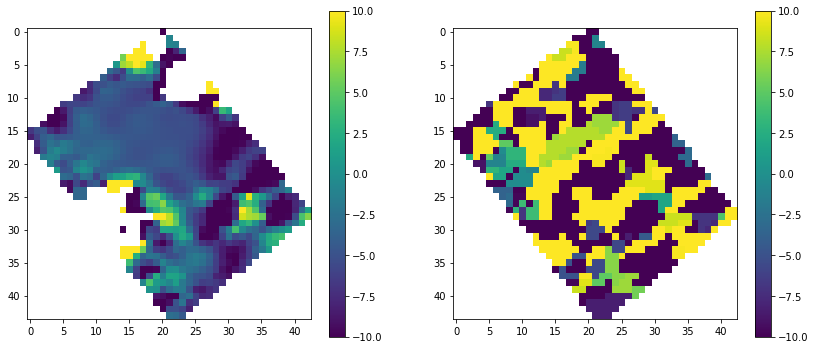

In [21]:
stackc = stackc.subcube_from_regions(regsm)
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = stackc.moment0()
m0.quicklook()
pl.title("m0")

pl.subplot(1,3,2)
mx = stackc.max(axis=0)
mx.quicklook()
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 0.00016*jtok
msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=5)
pl.imshow(msk, interpolation='none', origin='lower')
pl.tight_layout()
pl.figure()


m1 = stackc.with_mask(msk).with_mask(stackc > 0.0005*jtok).moment1()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1)
im = ax1.imshow(m1.value, vmin=-10, vmax=10)
pl.colorbar(mappable=im)
mxv = stackc.with_mask(msk).argmax_world(axis=0)
pl.subplot(1,2,2)
pl.imshow(mxv.value, vmin=-10, vmax=10)
pl.colorbar()


vmap = m1.hdu

invalid value encountered in true_divide


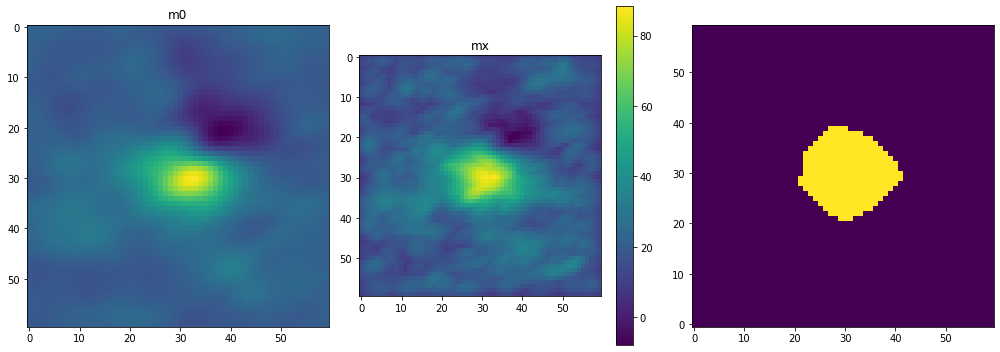

<Figure size 432x288 with 0 Axes>

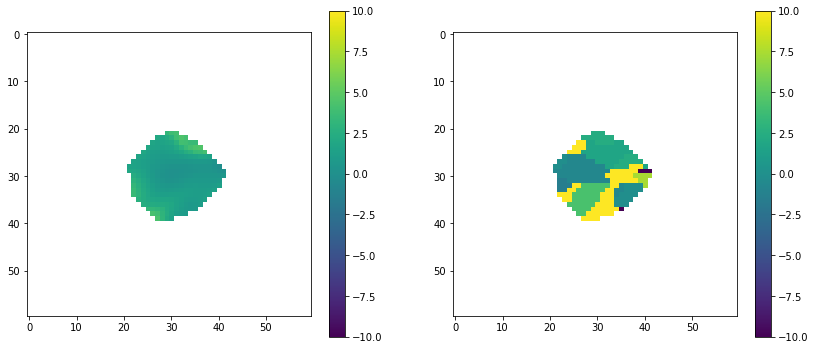

In [22]:
# try creating a vmap based on another line
restval = 232.6867*u.GHz # 'H2Ov2=1_5(5,0)-6(4,3)': 
cube = [c for c in cubes if (c.spectral_extrema[0] < restval) & (c.spectral_extrema[1] > restval)][0]
scube = cube.subcube_from_regions(reg).with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=restval).spectral_slab(-20*u.km/u.s, 20*u.km/u.s)
pl.figure(figsize=(14,5))
pl.subplot(1,3,1)
m0 = scube.moment0()
m0.quicklook()
pl.title("m0")

pl.subplot(1,3,2)
mx = scube.max(axis=0)
mx.quicklook()
pl.title("mx")
pl.colorbar()
pl.subplot(1,3,3)
msk = mx > 0.0075*jtok
msk = scipy.ndimage.binary_erosion(msk, iterations=1)
msk = scipy.ndimage.binary_dilation(msk, iterations=5)
pl.imshow(msk, interpolation='none', origin='lower')
pl.tight_layout()
pl.figure()


m1 = scube.with_mask(msk).with_mask(scube > 0.0005*jtok).moment1()
pl.figure(figsize=(14,6))
ax1 = pl.subplot(1,2,1)
im = ax1.imshow(m1.value, vmin=-10, vmax=10)
pl.colorbar(mappable=im)
mxv = scube.with_mask(msk).argmax_world(axis=0)
pl.subplot(1,2,2)
pl.imshow(mxv.value, vmin=-10, vmax=10)
pl.colorbar()


vmap = m1.hdu
# the rest value selected above was just the line center; we need to assume it's really 32 km/s off
#vmap.data = vmap.data

In [23]:
import sys
sys.path.append('/orange/adamginsburg/salt/code/')
from overplot_saltlines import overplot_saltlines

In [24]:
spectra = []
for ii,cube in enumerate(cubes):
    cube.allow_huge_operations=True
    sp = cube.subcube_from_regions(reg).mean(axis=(1,2))
    pysp = pyspeckit.Spectrum(data=sp, xarr=sp.spectral_axis, header=sp.header)
    spectra.append(pysp)
    pysp.specname = f'spw{ii+1}'

In [25]:
mkdir -p spectra/figures

spw1
spw2
spw3
spw4


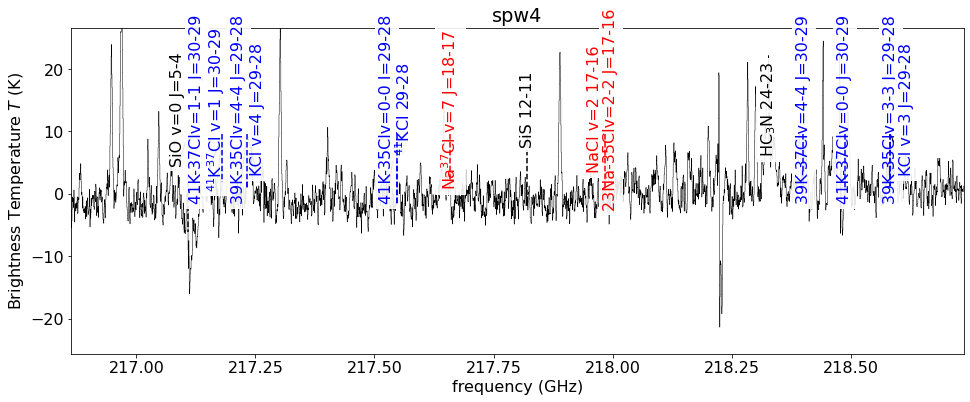

In [26]:
overplot_saltlines(spectra, vcen=vcen, savepath='spectra/figures')

In [27]:
ls spectra/figures

color_labels_NGC_6334_I_N_spw0_stack.png
color_labels_NGC_6334_I_N_spw1_stack.png
color_labels_NGC_6334_I_N_spw2_stack.png
color_labels_NGC_6334_I_N_spw3_stack.png
color_labels_spw1.png
color_labels_spw2.png
color_labels_spw3.png
color_labels_spw4.png
NGC_6334_I_N.config8.spw0.robust0.5.image_cb_smaller_stack.pdf
NGC_6334_I_N.config8.spw0.robust0.5.image_cb_smaller_stack.png
NGC_6334_I_N.config8.spw0.robust0.5.image_IN3_smaller_stack.pdf
NGC_6334_I_N.config8.spw0.robust0.5.image_IN3_smaller_stack.png
NGC_6334_I_N.config8.spw1.robust0.5.image_cb_smaller_stack.pdf
NGC_6334_I_N.config8.spw1.robust0.5.image_cb_smaller_stack.png
NGC_6334_I_N.config8.spw1.robust0.5.image_IN3_smaller_stack.pdf
NGC_6334_I_N.config8.spw1.robust0.5.image_IN3_smaller_stack.png
NGC_6334_I_N.config8.spw2.robust0.5.image_cb_smaller_stack.pdf
NGC_6334_I_N.config8.spw2.robust0.5.image_cb_smaller_stack.png
NGC_6334_I_N.config8.spw2.robust0.5.image_IN3_smaller_stack.pdf
NGC_6334_I_N.config8.spw2.robust0.5.image_IN3_smal

In [28]:
from IPython.display import Image,display

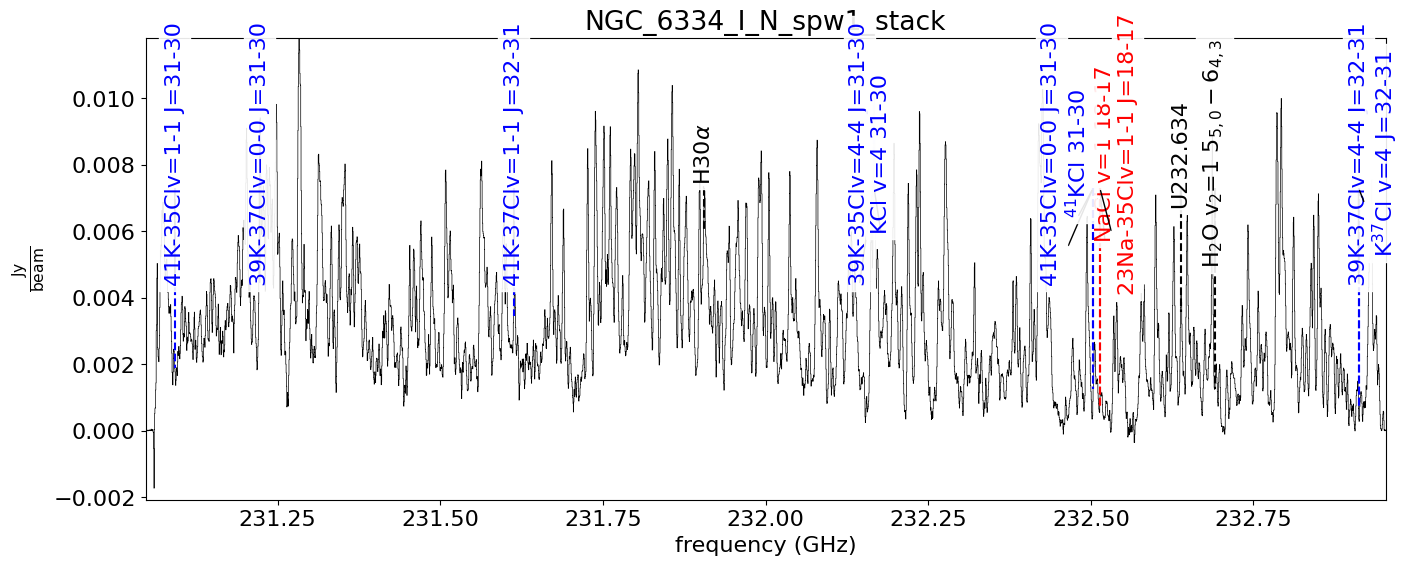

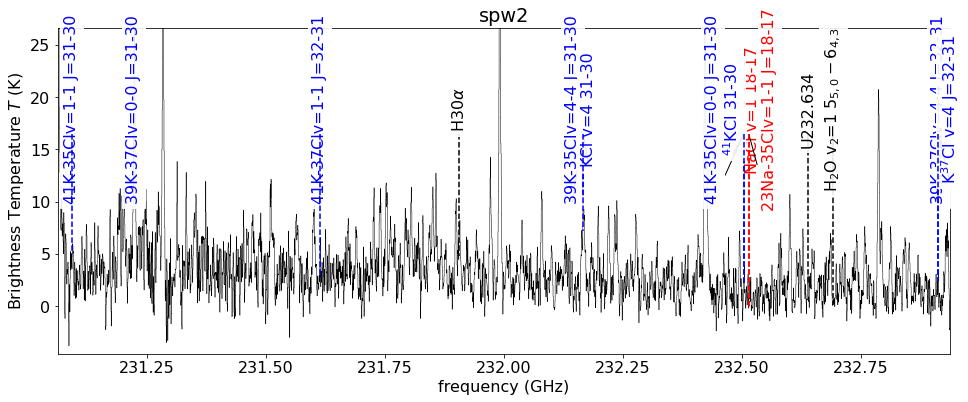

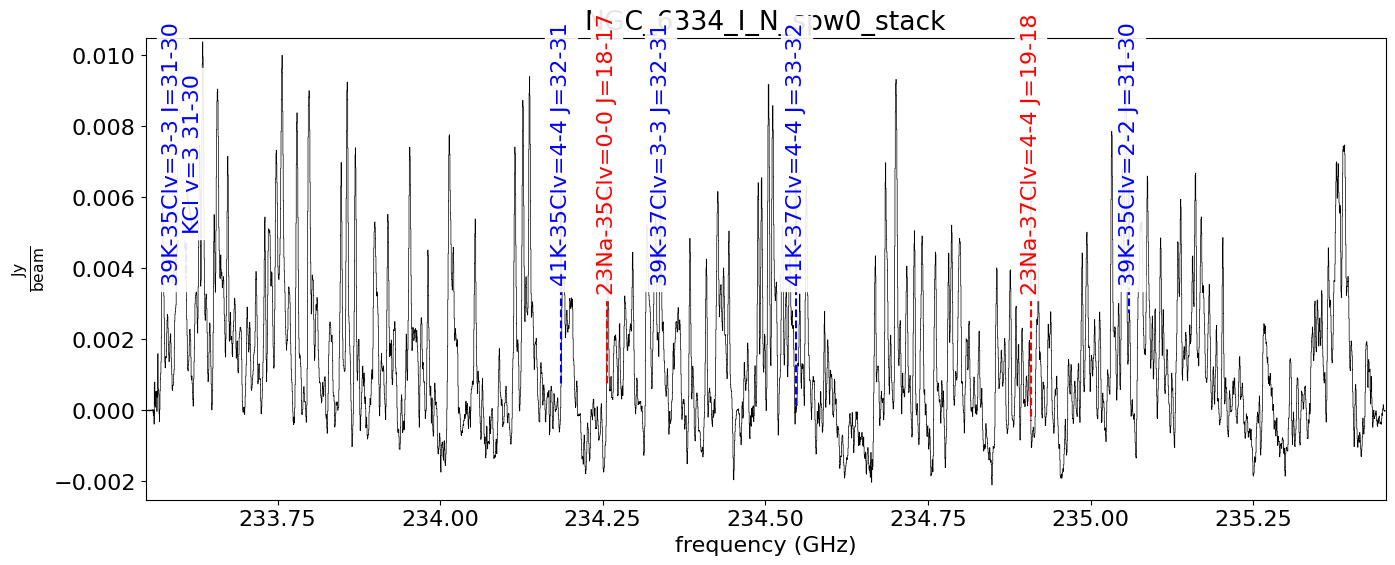

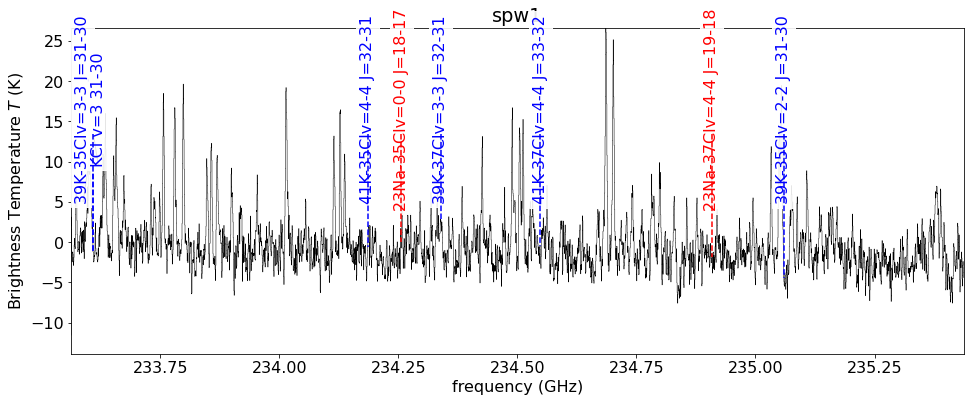

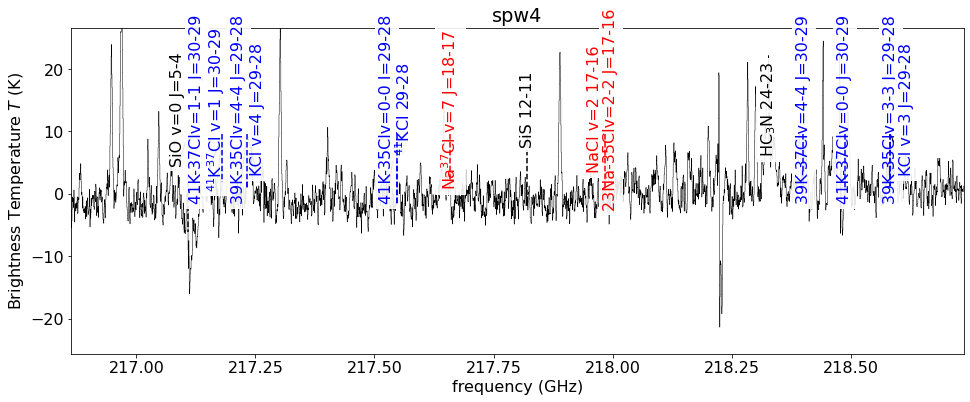

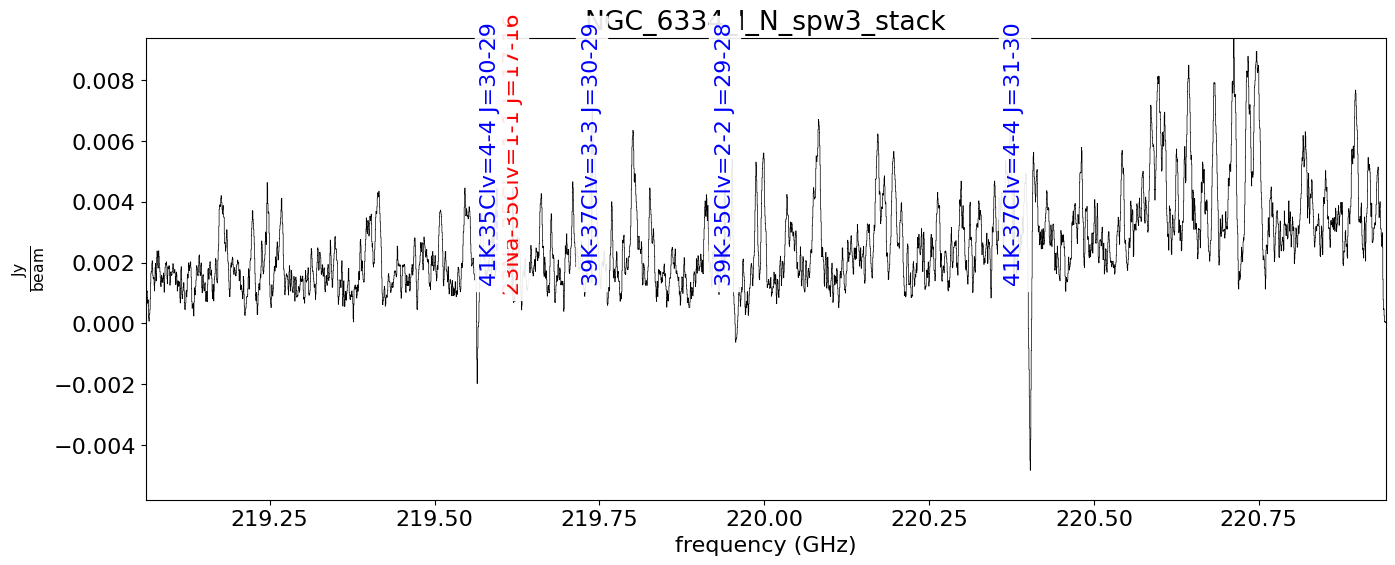

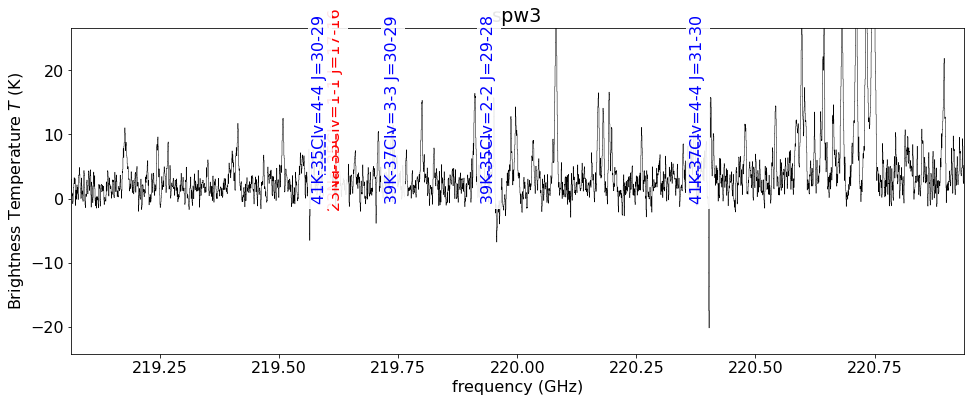

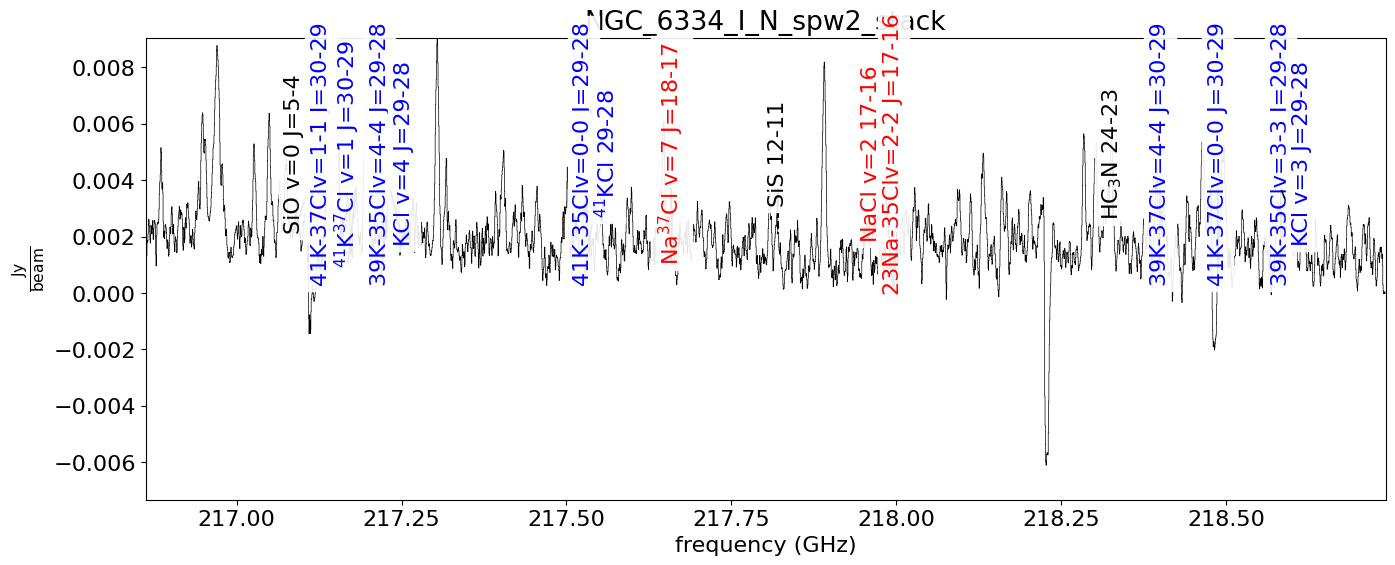

In [29]:
for fn in glob.glob('spectra/figures/color*png'):
    display(Image(fn))

In [30]:
print("TEST")

TEST


DaskSpectralCube with shape=(3840, 60, 60) and unit=K and chunk size (3840, 60, 60):
 n_x:     60  type_x: RA---SIN  unit_x: deg    range:   260.227389 deg:  260.227571 deg
 n_y:     60  type_y: DEC--SIN  unit_y: deg    range:   -35.754898 deg:  -35.754750 deg
 n_s:   3840  type_s: FREQ      unit_s: Hz     range: 233562724480.800 Hz:235437314159.321 Hz
Mean spectrum
Stacking
DaskSpectralCube with shape=(3840, 60, 60) and unit=K and chunk size (3840, 60, 60):
 n_x:     60  type_x: RA---SIN  unit_x: deg    range:   260.227389 deg:  260.227571 deg
 n_y:     60  type_y: DEC--SIN  unit_y: deg    range:   -35.754898 deg:  -35.754750 deg
 n_s:   3840  type_s: FREQ      unit_s: Hz     range: 231062724274.800 Hz:232937313953.321 Hz
Mean spectrum
Stacking
DaskSpectralCube with shape=(3840, 60, 60) and unit=K and chunk size (3840, 60, 60):
 n_x:     60  type_x: RA---SIN  unit_x: deg    range:   260.227389 deg:  260.227571 deg
 n_y:     60  type_y: DEC--SIN  unit_y: deg    range:   -35.754898 deg:

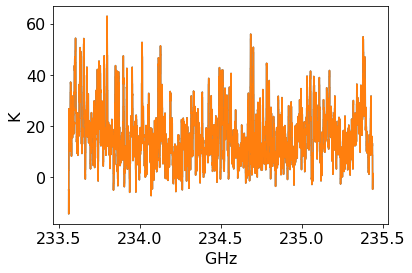

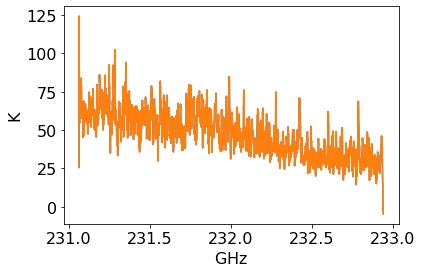

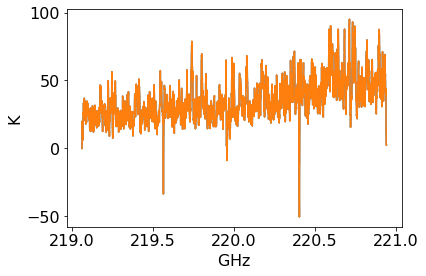

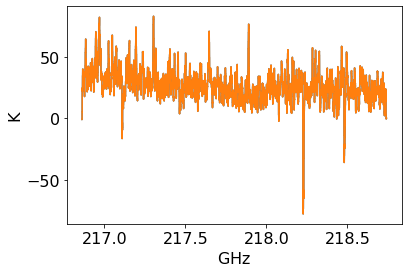

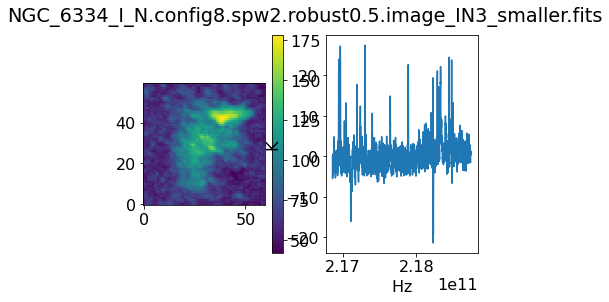

In [31]:
import glob
import spectral_cube.analysis_utilities
import reproject
from tqdm.notebook import tqdm

cbflist = (glob.glob('NGC_6334_I_N.config8.spw[0-3].robust0.5.image_IN3_smaller.fits'))
for fn in cbflist:
    basename = os.path.split(fn)[-1].split(".fits")[0]
    try:
        cube = SpectralCube.read(fn, use_dask=True)
    except Exception as ex:
        print(ex)
        continue
    print(cube)
    scube = cube.subcube_from_regions(reg)
    mx = scube.max(axis=0)
    #msk = mx > 0.003*mx.unit
    print("Mean spectrum")
    sp = scube.mean(axis=(1,2))
    
    sp.write(f'spectra/{fn.split("/")[-1].replace(".fits","_meanspec.fits")}', overwrite=True)


    # reproject the velocity map into the cube's coordinate system
    vmap_proj,_ = reproject.reproject_interp(vmap,
                                             scube.wcs.celestial,
                                             shape_out=scube.shape[1:])
    vmap_proj = u.Quantity(vmap_proj, u.km/u.s)

    # convert to km/s with arbitrary rest value so 0 km/s can be interpreted
    if scube.spectral_axis.unit.is_equivalent(u.Hz):
        scube = scube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=scube.spectral_axis.mean())

    print("Stacking")
    # perform the stacking!
    stack = spectral_cube.analysis_utilities.stack_spectra(scube, vmap_proj,
                                                           v0=0.0*u.km/u.s,
                                                           #progressbar=tqdm,
                                                           #num_cores=8
                                                          )
    fstack = stack.with_spectral_unit(u.GHz)

    pl.suptitle(f"{fn}")
    fstack.write(f'spectra/{basename}_stack.fits', overwrite=True)

    pl.clf()
    fstack.quicklook(filename=f'spectra/figures/{basename}_stack.pdf')
    fstack.quicklook(filename=f'spectra/figures/{basename}_stack.png')
    
    
    fig = pl.figure()
    mappable = pl.subplot(1,2,1).imshow(mx.value, origin='lower', interpolation='none')
    pl.colorbar(mappable)
    pl.subplot(1,2,2)
    pl.suptitle(fn)
    sp.quicklook()

In [32]:
ls spectra

figures/
NGC_6334_I_N.config8.spw0.robust0.5.image_cb_smaller_meanspec.fits
NGC_6334_I_N.config8.spw0.robust0.5.image_cb_smaller_stack.fits
NGC_6334_I_N.config8.spw0.robust0.5.image_IN3_smaller_meanspec.fits
NGC_6334_I_N.config8.spw0.robust0.5.image_IN3_smaller_stack.fits
NGC_6334_I_N.config8.spw1.robust0.5.image_cb_smaller_meanspec.fits
NGC_6334_I_N.config8.spw1.robust0.5.image_cb_smaller_stack.fits
NGC_6334_I_N.config8.spw1.robust0.5.image_IN3_smaller_meanspec.fits
NGC_6334_I_N.config8.spw1.robust0.5.image_IN3_smaller_stack.fits
NGC_6334_I_N.config8.spw2.robust0.5.image_cb_smaller_meanspec.fits
NGC_6334_I_N.config8.spw2.robust0.5.image_cb_smaller_stack.fits
NGC_6334_I_N.config8.spw2.robust0.5.image_IN3_smaller_meanspec.fits
NGC_6334_I_N.config8.spw2.robust0.5.image_IN3_smaller_stack.fits
NGC_6334_I_N.config8.spw3.robust0.5.image_cb_smaller_meanspec.fits
NGC_6334_I_N.config8.spw3.robust0.5.image_cb_smaller_stack.fits
NGC_6334_I_N.config8.spw3.robust0.5.image_IN3_smaller_meanspec.fits


In [33]:
stackspectra = []
for ii,fn in enumerate(glob.glob('spectra/*_stack.fits')):
    pysp = pyspeckit.Spectrum(fn)
    basename = os.path.basename(fn)
    spl = basename.split(".")
    pysp.specname = f'{spl[0]}_{spl[2]}_stack'
    stackspectra.append(pysp)

NGC_6334_I_N_spw2_stack
NGC_6334_I_N_spw1_stack
NGC_6334_I_N_spw2_stack
NGC_6334_I_N_spw0_stack
NGC_6334_I_N_spw0_stack
NGC_6334_I_N_spw3_stack
NGC_6334_I_N_spw3_stack
NGC_6334_I_N_spw1_stack


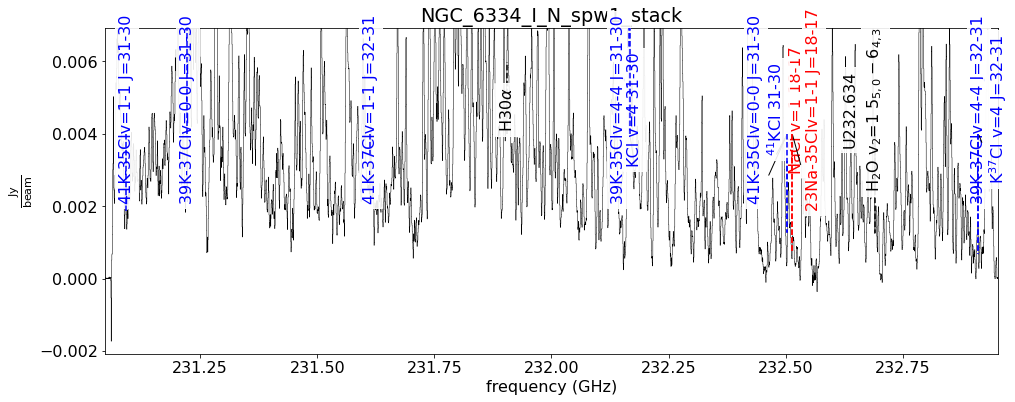

In [34]:
overplot_saltlines(stackspectra, vcen=vcen, savepath='spectra/figures')

In [35]:
ls spectra/figures/

color_labels_NGC_6334_I_N_spw0_stack.png
color_labels_NGC_6334_I_N_spw1_stack.png
color_labels_NGC_6334_I_N_spw2_stack.png
color_labels_NGC_6334_I_N_spw3_stack.png
color_labels_spw1.png
color_labels_spw2.png
color_labels_spw3.png
color_labels_spw4.png
NGC_6334_I_N.config8.spw0.robust0.5.image_cb_smaller_stack.pdf
NGC_6334_I_N.config8.spw0.robust0.5.image_cb_smaller_stack.png
NGC_6334_I_N.config8.spw0.robust0.5.image_IN3_smaller_stack.pdf
NGC_6334_I_N.config8.spw0.robust0.5.image_IN3_smaller_stack.png
NGC_6334_I_N.config8.spw1.robust0.5.image_cb_smaller_stack.pdf
NGC_6334_I_N.config8.spw1.robust0.5.image_cb_smaller_stack.png
NGC_6334_I_N.config8.spw1.robust0.5.image_IN3_smaller_stack.pdf
NGC_6334_I_N.config8.spw1.robust0.5.image_IN3_smaller_stack.png
NGC_6334_I_N.config8.spw2.robust0.5.image_cb_smaller_stack.pdf
NGC_6334_I_N.config8.spw2.robust0.5.image_cb_smaller_stack.png
NGC_6334_I_N.config8.spw2.robust0.5.image_IN3_smaller_stack.pdf
NGC_6334_I_N.config8.spw2.robust0.5.image_IN3_smal

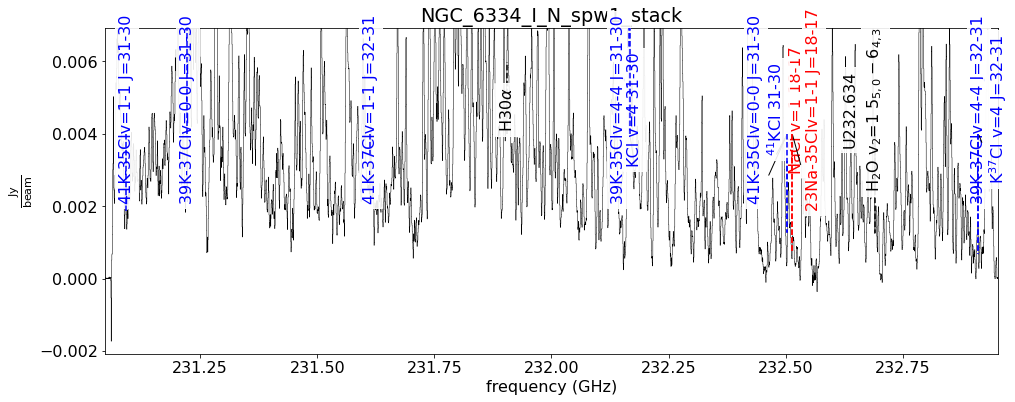

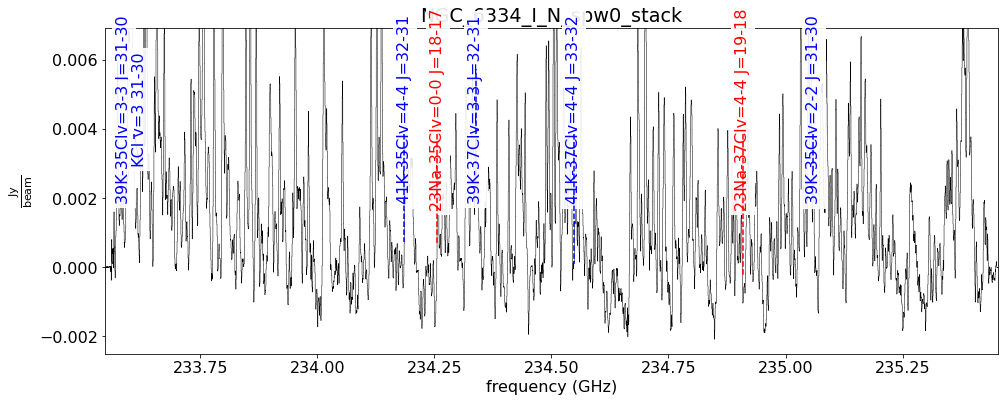

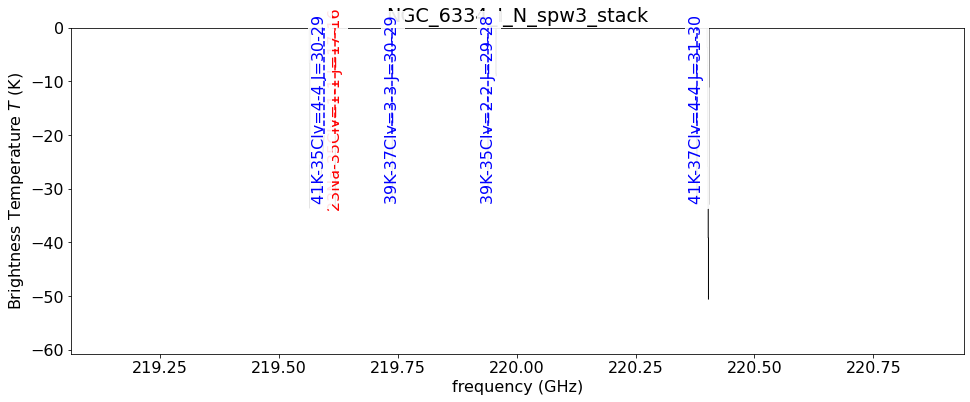

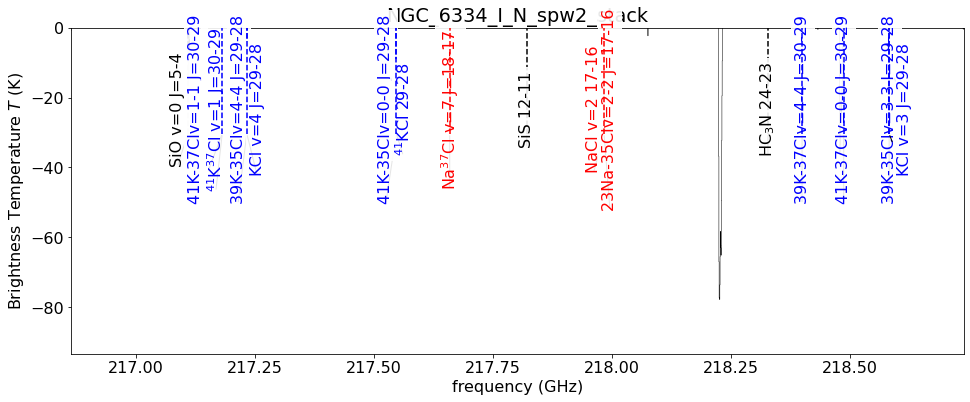

In [36]:
for fn in glob.glob('spectra/figures/color*stack.png'):
    display(Image(fn))